In [1]:
# Importing Libaries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skforecast as sk
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_state = 123
np.random.seed(random_state)

In [2]:
# Importing Data 
raw_train_data = pd.read_csv('data/train_data.csv')
raw_test_data = pd.read_csv('data/test.csv')
raw_train_data.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline
0,2021-06-30,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4
1,2021-06-30,C,"F6, F8, F9, F14, F17, F18",D37,12736,13111,655,823,211,29,17,2,1
2,2021-06-30,C,"F1, F4, F6, F7, F13, F15, F16",D34,14562,15651,1028,1910,225,35,47,3,1
3,2021-06-30,C,"F2, F6, F7, F10, F12, F13, F14, F15, F19",D45,11165,11467,514,769,56,39,29,0,1
4,2021-06-30,C,"F6, F8, F13, F14, F17",D50,10006,10423,399,842,52,60,65,1,1


In [3]:
raw_train_data.shape, raw_test_data.shape

((11309, 13), (2389, 12))

In [4]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11309 entries, 0 to 11308
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ofd_date      11309 non-null  object
 1   country_code  11309 non-null  object
 2   fc_codes      11309 non-null  object
 3   station_code  11309 non-null  object
 4   OFD           11309 non-null  int64 
 5   Slam          11309 non-null  int64 
 6   Earlies_Exp   11309 non-null  int64 
 7   Earlies_Rec   11309 non-null  int64 
 8   MNR_SNR_Exp   11309 non-null  int64 
 9   Rollover      11309 non-null  int64 
 10  Returns       11309 non-null  int64 
 11  R_Sideline    11309 non-null  int64 
 12  Sideline      11309 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


## Preprocessing

In [5]:
def set_data_types(data):
    '''Changes data types to correct type.'''
    
    data['ofd_date'] = pd.to_datetime(data.ofd_date, format='%Y-%m-%d')
    return data

def create_target(data):
    '''Creates target variable (Earlies_Exp - MNR_SNR_Exp) and drops those variables.'''
    
    data['target'] = data['Earlies_Exp'] - data['MNR_SNR_Exp']
    data = data.drop(['Earlies_Exp','MNR_SNR_Exp'], axis=1)
    return data


def apply_preprocessing(data, train=True):
    '''Takes all basic preprocessing functions and applies them in one function. Set train to false for test set as no target can be created.'''
    
    data = set_data_types(data)
    if train:
        data = create_target(data)
    return data[::-1]

train_data = apply_preprocessing(raw_train_data)
test_data = apply_preprocessing(raw_test_data, train=False)

# Basic Analysis

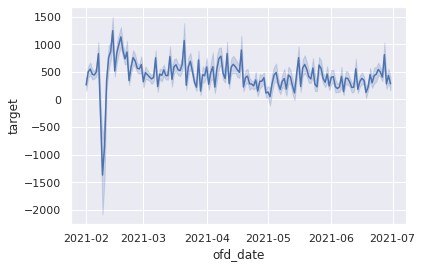

In [6]:
sns.set()
sns.lineplot(data=train_data, x='ofd_date', y='target');

In [7]:
train_data.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,target
11308,2021-02-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,356,2,249
11307,2021-02-01,D,"F35, F36, F40, F42, F43, F46, F48, F49, F52, F...",D59,16828,16504,333,135,112,256,1,165
11306,2021-02-01,D,"F35, F48, F52, F53, F54, F56",D69,12479,12345,196,64,62,136,0,99
11305,2021-02-01,D,"F35, F36, F37, F38, F39, F40, F42, F43, F44, F...",D54,18986,18861,446,100,107,248,1,235
11304,2021-02-01,D,"F35, F37, F38, F39, F40, F42, F43, F44, F46, F...",D60,16025,15768,383,69,195,15,1,425


In [8]:
train_data = train_data.reset_index().set_index('ofd_date').drop('index', axis=1)
train_data.head()

,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,target
ofd_date,,,,,,,,,,,
2021-02-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,356,2,249
2021-02-01,D,"F35, F36, F40, F42, F43, F46, F48, F49, F52, F...",D59,16828,16504,333,135,112,256,1,165
2021-02-01,D,"F35, F48, F52, F53, F54, F56",D69,12479,12345,196,64,62,136,0,99
2021-02-01,D,"F35, F36, F37, F38, F39, F40, F42, F43, F44, F...",D54,18986,18861,446,100,107,248,1,235
2021-02-01,D,"F35, F37, F38, F39, F40, F42, F43, F44, F46, F...",D60,16025,15768,383,69,195,15,1,425


In [25]:
train_data.groupby("station_code")["OFD"].count().describe()

count     80.000000
mean     141.362500
std       12.106326
min      121.000000
25%      127.250000
50%      149.000000
75%      150.000000
max      150.000000
Name: OFD, dtype: float64

In [9]:
train_data.shape[0]*0.3

3392.7

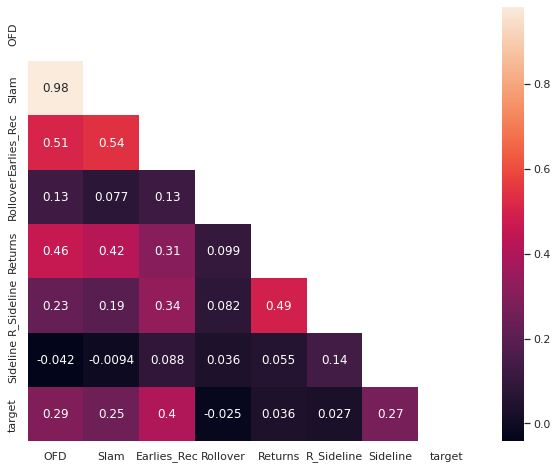

In [12]:
num_cols = [col for col in train_data.columns if train_data[col].dtype != 'O']
corrMatrix = train_data[num_cols].corr()

sns.axes_style("white")
sns.set_style("white")
plt.figure(figsize=(10,8))
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrMatrix, annot=True, mask=mask);

## Modelling 

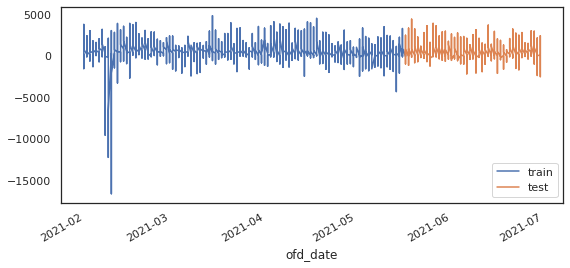

In [13]:
# Split data into train-test
# ==============================================================================
steps = 3400
data_train = train_data[:-steps]
data_test  = train_data[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
data_train['target'].plot(ax=ax, label='train')
data_test['target'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
num_cols.remove('target')

In [11]:
num_cols

['OFD',
 'Slam',
 'Earlies_Rec',
 'Rollover',
 'Returns',
 'R_Sideline',
 'Sideline',
 'target']

In [89]:
data_train = data_train.drop('target', axis=1)

In [91]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
data_train[num_cols] = scaler.fit_transform(data_train[num_cols])
data_test[num_cols] = scaler.transform(data_test[num_cols])

In [ ]:
train_data

- Remove the outlier - Normal or Weird occurence - Decreases the range 
- Add a column for the day of the week 
- Group by Station Id 
- Check for 1 station and see how it performs in terms of lags and other exogenous variables 
- Target variable should be shifted by 1 step before 

In [85]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=random_state),
                lags = 15)
forecaster.fit(y=data_train['target'], exog=data_train[num_cols])
forecaster

# Predictions 
predictions = forecaster.predict(steps=steps, exog=data_test[num_cols])

# Error
error_rmse = mean_squared_error(
                y_true = data_test['target'],
                y_pred = predictions, 
                squared=False)
print(f"Test error (rmse): {error_rmse}")


error_mse = mean_squared_error(
                y_true = data_test['target'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (rmse): 416.5886522818755
Test error (mse): 173546.1052100294


In [88]:
forecaster.get_feature_importance().sort_values(by="importance", ascending=False)

,feature,importance
0,lag_1,0.270262
17,Earlies_Rec,0.155540
1,lag_2,0.057266
15,OFD,0.056711
21,Sideline,0.054833
18,Rollover,0.040363
2,lag_3,0.037347
3,lag_4,0.028920
20,R_Sideline,0.028293
16,Slam,0.027843


## Final Predictions

In [77]:
test = test_data.reset_index().set_index('ofd_date').drop(['index', 'Unnamed: 0'], axis=1)
test.head()

,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline
ofd_date,,,,,,,,,,
2021-07-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,15562,15502,173,44,92,10,1
2021-07-01,D,"F35, F36, F40, F42, F43, F46, F48, F49, F52, F...",D59,14633,14650,91,51,80,1,0
2021-07-01,D,"F35, F48, F52, F53, F54, F56",D69,10733,10801,54,26,64,1,0
2021-07-01,D,"F35, F36, F37, F38, F39, F40, F42, F43, F44, F...",D54,16615,16643,222,37,95,1,0
2021-07-01,D,"F35, F37, F38, F39, F40, F42, F43, F44, F46, F...",D60,11782,14462,113,34,88,0,0
